In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np # linear algebra
import pandas as pd
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from functools import reduce
from sklearn.metrics import ndcg_score

Loading the dataset

In [ ]:
df = pd.read_csv("rating_final.csv")
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [ ]:
dfcuisine = pd.read_csv('chefmozcuisine.csv')
dfaccepts = pd.read_csv('chefmozaccepts.csv')
dfpark = pd.read_csv('chefmozparking.csv')

Cleaning and Preprocessing of dataset

In [ ]:
df_grouped1 = dfcuisine.groupby('placeID')['Rcuisine'].apply(list).reset_index(name='cuisine')
df_grouped2 = dfaccepts.groupby('placeID')['Rpayment'].apply(list).reset_index(name='payment')
df_grouped3 = dfpark.groupby('placeID')['parking_lot'].apply(list).reset_index(name='parking')

In [ ]:
df_grouped = reduce(lambda x,y: pd.merge(x,y, on='placeID'), [df_grouped1, df_grouped2, df_grouped3])

In [ ]:
df_grouped['cstr'] = df_grouped.cuisine.apply(lambda x: ' '.join([str(i) for i in x]))
df_grouped['pstr'] = df_grouped.payment.apply(lambda x: ' '.join([str(i) for i in x]))
df_grouped['plstr'] = df_grouped.parking.apply(lambda x: ' '.join([str(i) for i in x]))

In [ ]:
df_grouped

,placeID,cuisine,payment,parking,cstr,pstr,plstr
0,132012,"[French, Dutch-Belgian]","[Visa, American_Express, bank_debit_cards, Din...","[public, street]",French Dutch-Belgian,Visa American_Express bank_debit_cards Diners_...,public street
1,132023,"[French, Dutch-Belgian]","[American_Express, Japan_Credit_Bureau, bank_d...","[fee, public]",French Dutch-Belgian,American_Express Japan_Credit_Bureau bank_debi...,fee public
2,132024,"[Seafood, Continental-European]","[Visa, American_Express, bank_debit_cards, Din...",[street],Seafood Continental-European,Visa American_Express bank_debit_cards Diners_...,street
3,132026,[Dutch-Belgian],"[Visa, American_Express, bank_debit_cards, Din...",[fee],Dutch-Belgian,Visa American_Express bank_debit_cards Diners_...,fee
4,132030,"[French, Dutch-Belgian]","[Visa, American_Express, gift_certificates, ba...",[street],French Dutch-Belgian,Visa American_Express gift_certificates bank_d...,street
...,...,...,...,...,...,...,...
458,135105,[Fast_Food],[cash],[none],Fast_Food,cash,none
459,135106,[Mexican],"[cash, VISA, MasterCard-Eurocard]",[none],Mexican,cash VISA MasterCard-Eurocard,none
460,135107,[Latin_American],"[cash, VISA, MasterCard-Eurocard, American_Exp...",[none],Latin_American,cash VISA MasterCard-Eurocard American_Express...,none
461,135109,[Italian],[cash],[none],Italian,cash,none


In [ ]:
df_grouped['combined'] = df_grouped['cstr']+ ' ' + df_grouped['pstr'] + ' ' + df_grouped['plstr']

In [ ]:
df_grouped

,placeID,cuisine,payment,parking,cstr,pstr,plstr,combined
0,132012,"[French, Dutch-Belgian]","[Visa, American_Express, bank_debit_cards, Din...","[public, street]",French Dutch-Belgian,Visa American_Express bank_debit_cards Diners_...,public street,French Dutch-Belgian Visa American_Express ban...
1,132023,"[French, Dutch-Belgian]","[American_Express, Japan_Credit_Bureau, bank_d...","[fee, public]",French Dutch-Belgian,American_Express Japan_Credit_Bureau bank_debi...,fee public,French Dutch-Belgian American_Express Japan_Cr...
2,132024,"[Seafood, Continental-European]","[Visa, American_Express, bank_debit_cards, Din...",[street],Seafood Continental-European,Visa American_Express bank_debit_cards Diners_...,street,Seafood Continental-European Visa American_Exp...
3,132026,[Dutch-Belgian],"[Visa, American_Express, bank_debit_cards, Din...",[fee],Dutch-Belgian,Visa American_Express bank_debit_cards Diners_...,fee,Dutch-Belgian Visa American_Express bank_debit...
4,132030,"[French, Dutch-Belgian]","[Visa, American_Express, gift_certificates, ba...",[street],French Dutch-Belgian,Visa American_Express gift_certificates bank_d...,street,French Dutch-Belgian Visa American_Express gif...
...,...,...,...,...,...,...,...,...
458,135105,[Fast_Food],[cash],[none],Fast_Food,cash,none,Fast_Food cash none
459,135106,[Mexican],"[cash, VISA, MasterCard-Eurocard]",[none],Mexican,cash VISA MasterCard-Eurocard,none,Mexican cash VISA MasterCard-Eurocard none
460,135107,[Latin_American],"[cash, VISA, MasterCard-Eurocard, American_Exp...",[none],Latin_American,cash VISA MasterCard-Eurocard American_Express...,none,Latin_American cash VISA MasterCard-Eurocard A...
461,135109,[Italian],[cash],[none],Italian,cash,none,Italian cash none


Creating the dataset for BERT embeddings

In [ ]:
df_joined = df_grouped.merge(df,on='placeID',how='right')

In [ ]:
len(df_joined['placeID'].unique())

130

In [ ]:
df_joined_filtered = df_joined[['placeID','combined']]

In [ ]:
len(df_joined_filtered['placeID'].unique())

130

In [ ]:
df1 = df_joined_filtered.drop_duplicates()

In [ ]:
df1.reset_index(inplace=True,drop=True)

In [ ]:
df1.fillna('')

,placeID,combined
0,135085,Fast_Food cash public
1,135038,
2,132825,Mexican cash none
3,135060,Seafood cash none
4,135104,Mexican cash VISA MasterCard-Eurocard yes
...,...,...
125,132951,American cash yes
126,132937,Bar cash none
127,132954,Breakfast-Brunch cash VISA MasterCard-Eurocard...
128,132955,Bar_Pub_Brewery cash VISA MasterCard-Eurocard ...


Matrix Factorization Preparation

In [ ]:
user_id_dict = {}
k=0
for i in df['userID']:
  if i not in user_id_dict:
    user_id_dict[i] = k
    k+=1

recipe_id_dict = {}
k=0
for i in df['placeID']:
  if i not in recipe_id_dict:
    recipe_id_dict[i] = k
    k+=1

In [ ]:
df['user_id_ordered']= df['userID'].map(user_id_dict)
df

,userID,placeID,rating,food_rating,service_rating,user_id_ordered
0,U1077,135085,2,2,2,0
1,U1077,135038,2,2,1,0
2,U1077,132825,2,2,2,0
3,U1077,135060,1,2,2,0
4,U1068,135104,1,1,2,1
...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,136
1157,U1011,132715,1,1,0,137
1158,U1068,132733,1,1,0,1
1159,U1068,132594,1,1,1,1


In [ ]:
df['place_id_ordered']= df['placeID'].map(recipe_id_dict)
df

,userID,placeID,rating,food_rating,service_rating,user_id_ordered,place_id_ordered
0,U1077,135085,2,2,2,0,0
1,U1077,135038,2,2,1,0,1
2,U1077,132825,2,2,2,0,2
3,U1077,135060,1,2,2,0,3
4,U1068,135104,1,1,2,1,4
...,...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,136,8
1157,U1011,132715,1,1,0,137,21
1158,U1068,132733,1,1,0,1,10
1159,U1068,132594,1,1,1,1,23


In [ ]:
df_new = df[['user_id_ordered','place_id_ordered','rating']]

In [ ]:
df_new = df_new.rename(columns={'user_id_ordered':'userId','place_id_ordered':'placeId'})

In [ ]:
df_new = df_new.iloc[:100000, :]

In [ ]:
df_new.head()

,userId,placeId,rating
0,0,0,2
1,0,1,2
2,0,2,2
3,0,3,1
4,1,4,1


In [ ]:
X = df_new.iloc[:,:2]
Y = df_new.iloc[:,2]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

Loading pre-trained BERT sentence encoder (Used cuisine, parking lot and payment information for BERT embeddings, as sentence encoder takes sentences/paragraphs for encoding)

In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [ ]:
df1 = df1.applymap(str)

Creating embeddings for the places

In [ ]:
df1['Embeddings'] = df1['combined'].apply(lambda x: model.encode(x))

In [ ]:
df1['Embeddings'].shape

(130,)

In [ ]:
embeddings_matrix = np.empty((len(df1), 768))
for i in range(len(df1)):
  embeddings_matrix[i] = (df1['Embeddings'].loc[i])

In [ ]:
embeddings_matrix.shape

(130, 768)

In [ ]:
n_latent_factors = 768

n_users, n_recipes = len(df_new['userId'].unique()), len(df_new['placeId'].unique()) 

In [ ]:
n_recipes

130

Intializing the Model

In [ ]:
from keras.initializers import Constant
# recipe_embedding_matrix = np.random.random((n_recipes, n_latent_factors))
rest_embedding_matrix = embeddings_matrix
user_input = Input(shape=(1,), name='User_Input',dtype='int32')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


rest_input = Input(shape=(1,), name='Rest_Input',dtype='int32')
rest_embeddings = Embedding(input_dim = n_recipes, output_dim=n_latent_factors, input_length=1, 
                               name='Rest_Embedding',trainable=True,embeddings_initializer=Constant(rest_embedding_matrix)) (rest_input)
rest_vector = Flatten(name='Rest_Vector') (rest_embeddings)

print(user_vector.shape)
print(rest_vector.shape)

# Concatenate Product
merged_vectors = concatenate([user_vector, rest_vector], name='Concantenate')

print(merged_vectors.shape)
dense_layer_1 = Dense(100, activation='relu')(merged_vectors) 
dense_layer_1 = Dropout(0.25) (dense_layer_1)
batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


result = Dense(1)(dense_layer_1)
model = Model([user_input, rest_input], result)

(None, 768)
(None, 768)
(None, 1536)


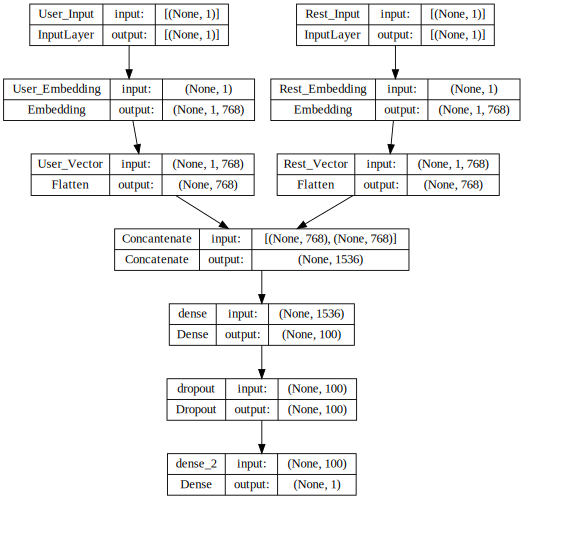

In [ ]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Rest_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 768)       105984      ['User_Input[0][0]']             
                                                                                                  
 Rest_Embedding (Embedding)     (None, 1, 768)       99840       ['Rest_Input[0][0]']             
                                                                                              

In [ ]:
# !pip install tensorflow_ranking

Setting the metrics - NDCG and MRR and loss function - MAE

In [ ]:
import tensorflow_ranking as tfr

from tensorflow import keras
from keras.metrics import top_k_categorical_accuracy,MeanAbsoluteError
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=False),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=False)
]
optimizer = adam_v2.Adam(learning_rate = 0.005)

model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=[keras.metrics.MeanAbsoluteError(),'top_k_categorical_accuracy',eval_metrics])

In [ ]:
batch_size = 50
epochs = 10

In [ ]:
y_test.head()

397    1
726    0
986    2
918    1
117    2
Name: rating, dtype: int64

Training the model

In [ ]:
history = model.fit(x=[x_train['userId'], x_train['placeId']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2,validation_data=([x_test['userId'], x_test['placeId']], y_test))

Epoch 1/10
19/19 - 9s - loss: 2.1214 - mean_absolute_error: 1.1479 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7866 - metric/mrr: 0.7866 - val_loss: 0.6649 - val_mean_absolute_error: 0.6909 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7597 - val_metric/mrr: 0.7597 - 9s/epoch - 465ms/step
Epoch 2/10
19/19 - 0s - loss: 0.6119 - mean_absolute_error: 0.6345 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7866 - metric/mrr: 0.7866 - val_loss: 0.5359 - val_mean_absolute_error: 0.6005 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7597 - val_metric/mrr: 0.7597 - 370ms/epoch - 19ms/step
Epoch 3/10
19/19 - 0s - loss: 0.4410 - mean_absolute_error: 0.5274 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7866 - metric/mrr: 0.7866 - val_loss: 0.5167 - val_mean_absolute_error: 0.5706 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7597 - val_metric/mrr: 0.7597 - 403ms/epoch - 21ms/step
Epoch 4/10
19/19 - 1s - loss: 0.4053 - mean_abso

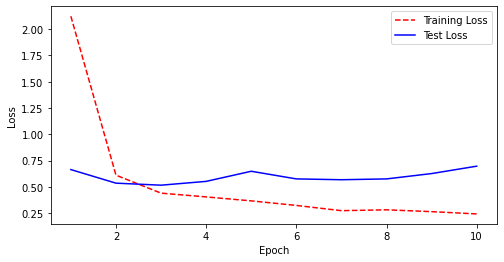

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
score = model.evaluate([x_test['userId'], x_test['placeId']], y_test)


8/8 [==============================] - 0s 7ms/step - loss: 0.6973 - mean_absolute_error: 0.6510 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7597 - metric/mrr: 0.7597


Extracting the new trained embeddings

In [ ]:
embedding_layer = model.get_layer(name="Rest_Embedding")
embeddings_new = embedding_layer.get_weights()

In [ ]:
len(embeddings_new[0])

130

In [ ]:
len(rest_embedding_matrix[0])

768

Fitting the old embeddings on KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10)
knn.fit(rest_embedding_matrix) #embedding vectors
# # select indices of k nearest neighbours
# neighbours = knn.kneighbors([x], return_distance = False)
# print(neighbours)

NearestNeighbors(n_neighbors=10)

In [ ]:
neighbours = knn.kneighbors([embeddings_new[0][0]], return_distance = False)
print(neighbours)

[[  0  22  52  18 121  15  30  74  79  35]]


In [ ]:
neighbours_old = knn.kneighbors([rest_embedding_matrix[0]], return_distance = False)
print(neighbours_old)

[[  0  22  52  18 121  15  30  74  79  35]]


In [ ]:
len(set(neighbours[0]).intersection(neighbours_old[0]))

10

Evaluating the results - NDCG, MRR and Top_K

In [ ]:
mrr = 0
top_k = 0
ndcg = 0
for i in range(len(rest_embedding_matrix)):
  neighbours = knn.kneighbors([embeddings_new[0][i]], return_distance = False)
  neighbours_old = knn.kneighbors([rest_embedding_matrix[i]], return_distance = False)
  ndcg += ndcg_score(neighbours_old,neighbours)
  count = 0
  for i in range(len(neighbours[0])):
    if neighbours[0][i] in neighbours_old[0:10] and i!=neighbours[0][i]:
      count+=1
    if neighbours[0][i] in neighbours_old[0] and i!=neighbours[0][i]:
      mrr+=1/(i+1)
      break
  # print(top_k)
  top_k +=count
print("NDCG:",ndcg/len(rest_embedding_matrix))
print("Top_K:",top_k/len(rest_embedding_matrix))
normalized_top_k = top_k/len(rest_embedding_matrix)/10
print("Top_K - Normalized:",normalized_top_k)
print("MRR:",mrr/len(rest_embedding_matrix))

# NDCG: 0.9608688850983871
# Top_K: 1.0
# Top_K - Normalized: 0.1
# MRR: 0.9517094017094018

NDCG: 0.9608688850983871
Top_K: 1.0
Top_K - Normalized: 0.1
MRR: 0.9517094017094018
